In [1]:
import pandas as pd
import numpy as np
from hmmlearn.hmm import GaussianHMM
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv("../data/nifty_features_5min.csv")
df["datetime"] = pd.to_datetime(df["datetime"])
df = df.sort_values("datetime")

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18675 entries, 0 to 18674
Data columns (total 38 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   datetime             18675 non-null  datetime64[ns]
 1   spot_open            18675 non-null  float64       
 2   spot_high            18675 non-null  float64       
 3   spot_low             18675 non-null  float64       
 4   spot_close           18675 non-null  float64       
 5   spot_volume          18675 non-null  int64         
 6   fut_open             18675 non-null  float64       
 7   fut_high             18675 non-null  float64       
 8   fut_low              18675 non-null  float64       
 9   fut_close            18675 non-null  float64       
 10  fut_volume           18675 non-null  int64         
 11  opt_open             18675 non-null  float64       
 12  opt_high             18675 non-null  float64       
 13  opt_low              18675 non-

In [3]:
df["rolling_volatility"] = df["spot_return"].rolling(20).std()

In [4]:
regime_features = df[
    [
        "spot_return",
        "rolling_volatility",
        "futures_basis",
        "avg_iv",
        "gamma_exposure"
    ]
].dropna()

regime_features.head()


,spot_return,rolling_volatility,futures_basis,avg_iv,gamma_exposure
19,-0.001786,0.004053,0.0,0.064347,44.305265
20,0.006559,0.004368,0.0,0.069341,41.170120
21,0.002962,0.004391,0.0,0.069709,40.956465
22,-0.003544,0.004425,0.0,0.070252,40.644989
23,0.013634,0.005450,0.0,0.086521,33.094603


In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(regime_features)


In [6]:
hmm_model = GaussianHMM(
    n_components=3,          # 3 regimes
    covariance_type="full",
    n_iter=500,
    tol=1e-3,
    random_state=42
)

hmm_model.fit(X)


Model is not converging.  Current: 367749.2059028248 is not greater than 368494.2872586747. Delta is -745.081355849863


GaussianHMM(covariance_type='full', n_components=3, n_iter=500, random_state=42,
            tol=0.001)

In [7]:
regimes = hmm_model.predict(X)

regime_features["regime"] = regimes


In [8]:
df = df.loc[regime_features.index]
df["regime"] = regimes

df[["datetime", "regime"]].head()


,datetime,regime
19,2024-08-07 10:55:00,2
20,2024-08-07 11:00:00,2
21,2024-08-07 11:05:00,2
22,2024-08-07 11:10:00,2
23,2024-08-07 11:15:00,2


In [9]:
df["regime"].value_counts()


regime
2    18368
1      268
0       20
Name: count, dtype: int64

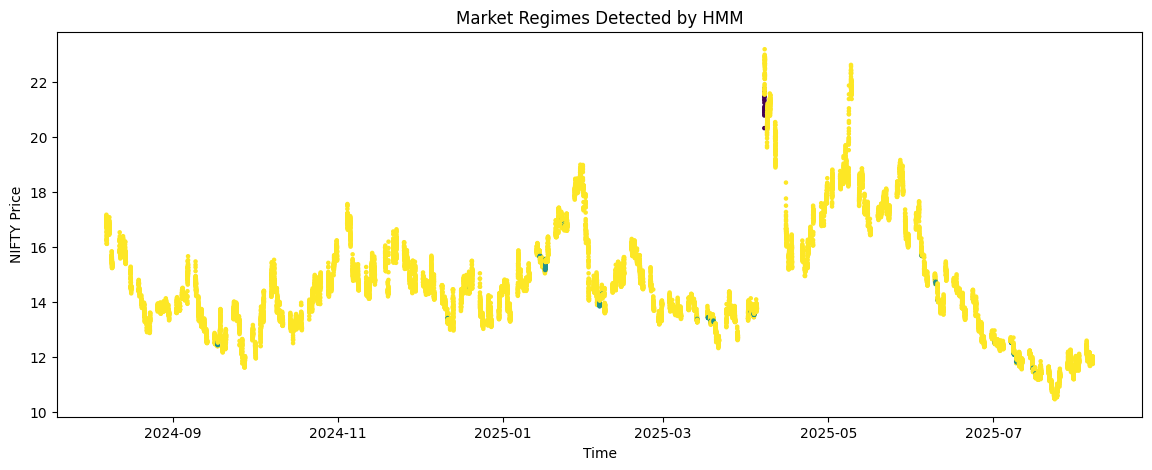

In [10]:
plt.figure(figsize=(14,5))
plt.scatter(
    df["datetime"],
    df["spot_close"],
    c=df["regime"],
    cmap="viridis",
    s=5
)
plt.title("Market Regimes Detected by HMM")
plt.xlabel("Time")
plt.ylabel("NIFTY Price")
plt.show()


In [11]:
df.groupby("regime")[[
    "spot_return",
    "rolling_volatility",
    "avg_iv",
    "futures_basis"
]].mean()


,spot_return,rolling_volatility,avg_iv,futures_basis
regime,,,,
0,0.028429,0.124684,1.979304,0.0
1,0.000089,0.001340,0.021270,0.0
2,-0.000028,0.004893,0.077672,0.0


In [12]:
regime_map = {
    0: "Range",
    1: "Trending",
    2: "Volatile"
}

df["regime_label"] = df["regime"].map(regime_map)


In [13]:
df.to_csv("../data/nifty_regime_5min.csv", index=False)


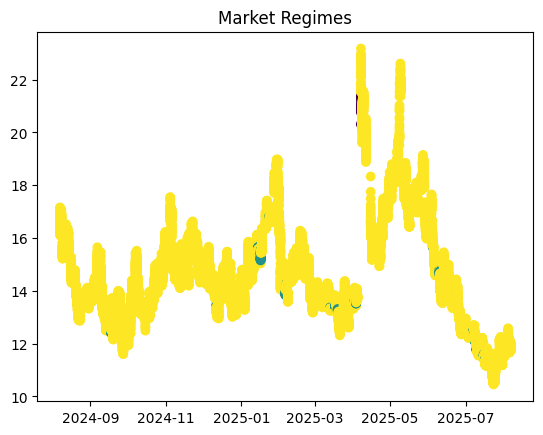

In [14]:
plt.scatter(df["datetime"], df["spot_close"], c=df["regime"])
plt.title("Market Regimes")

plt.savefig("../plots/regime_overlay.png", dpi=150, bbox_inches="tight")
plt.show()
